In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate, interpolate, signal, optimize, stats
import pickle
from sklearn import metrics
import h5py
import lal
import progressbar
import warnings
warnings.filterwarnings('ignore')
np.set_printoptions(edgeitems=30, linewidth=160)

In [2]:
# The name of the file that contains the simulated CCSN waveforms
filename = './Data/GWdatabase.h5'

# Read the simulated CCSN waveforms
waveformfile = h5py.File(filename, 'r')


# The first level keys of the h5 file
reduced_data = waveformfile.keys()[0]
waveformfilekey = waveformfile.keys()[1]
yeofrho = waveformfile.keys()[2]

waveformfamily = []
waveformfamily_keys = []

# Since there are 1824 different simulated CCSN waveform. 
# Each of which is saved in a different waveformfile key 
# So the loop below is to retreive all the keys with which the waveform strain data is accessed,
# and save it to waveformfamily.
# Each waveform family has 5 different keys, so the second part is to retrieve these 5 keys, and save them
# to waveformfamily_keys.

for i, key in enumerate(waveformfile[waveformfilekey].keys()):
    waveformfamily.append(key)
    if i == 0:
        for j, _ in enumerate(waveformfile[waveformfilekey][waveformfamily[i]].keys()):
            waveformfamily_keys.append(waveformfile[waveformfilekey][waveformfamily[i]].keys()[j])
originalSNR = np.array(waveformfile[reduced_data][u'SNR(aLIGOfrom10kpc)'])

In [3]:
# This is to set some parameters for the training.
# Since the waveforms are stored in the unit of strain * distan
# the waveform amplitudes need to be divided by a distance.

# Convection factor between par sec and meters
PctMe = lal.PC_SI

# The distance the waveform will be divided by, in centimeters
Dist = 10.0 * 1e3 * PctMe * 1e2

# Since the waveform samples come in different lengths, 
# so every waveform sample will be set to the longest length.
# findmax/findmin is a variable that saves the longest/shortest length of the waveform samples.
# k/kmin is the index referring to the longest/shortest waveform sample.
findmax = 0
k = 0 
findmin = 1e10
kmin = 0
#length = np.zeros(len(waveformfamily))
#waveformfamily = [waveformfamily[0]]
with open("abnormalwaves.pkl") as f:
    mark_nonzeros, mark_suddenjump = pickle.load(f)
abn_index = np.concatenate([mark_nonzeros, mark_suddenjump])    

# Since the waveform contains 1824 waveforms, which are different both in the morophology and the duration,
# training a network with all these waveforms may make it hard to debug. So one may want to limit the variation
# in the waveform samples by limiting the number of waveform samples put in the training. 
no_waves_considered = 1824
#allwave = []
#mark_nonzero=[]
for i in range(len(waveformfamily[0:no_waves_considered])):
    if i in abn_index:
        continue
    waveformnumber = i

    ts = np.array(waveformfile[waveformfilekey][waveformfamily[waveformnumber]][u't-tb(s)']) 
    #waves = np.array(waveformfile[waveformfilekey][waveformfamily[waveformnumber]][u'strain*dist(cm)']) / Dist 
    #allwave.append(waves)
    if findmax < len(ts):
        findmax = len(ts)
        k = i
    if findmin > len(ts):
        findmin = len(ts)
        kmin = i

print(findmax, k, findmin, kmin)


(56839, 670, 13156, 1416)


In [4]:
# The simulated waveforms are sampled with a sampling rate equal to 65535 Hz, 
# coupled with the longest waveform is ~1.66s, this makes the longest waveform contains 1e5 elements. 
# Since this code will make other waveforms the same length as the longest length, this requires huge amount of memory,
# and makes training very slow and difficult. 
# Therefore, this codes uses scipy.signal.decimate to down sample the waveforms


def padandextractwave(waveformfile, waveformfilekey, waveformfamily, strainkey, wavemaxlength, Dist, no_waves_considered, R, abn_index, alpha, use_window):
    # Number of simulated waveforms considered
    actualwavenumber = no_waves_considered - len(abn_index)
    noofwaves = len(waveformfamily[0:actualwavenumber])
    
    msg = 'Reading waveforms from file and downsampling them by a factor of %s............' %(R)
    print(msg)
    bar = progressbar.ProgressBar(max_value = actualwavenumber)
    
    # downsample factor, the downsampled waveform will have length = original length / R
    
    # Vector used to save the downsampled waveform
    downsampled_waveforms = np.array([np.zeros(wavemaxlength / R) for i in range(noofwaves)])
    wave_take_in = 0
    for i, whichsimulation in enumerate(waveformfamily[0:no_waves_considered]):
        
        if i in abn_index:
            continue
        
        # convert the unit of the waveform from strain*distance to strain
        wave = np.array(waveformfile[waveformfilekey][whichsimulation][strainkey]) / Dist
        wavelength = len(wave)
        
        
        if use_window == True:
            windows = signal.tukey(wavelength, alpha = alpha)
        else:
            windows = np.ones(wavelength)
        wave = windows * wave
        # Pad the waveform with zero so that it has the same length as the longest waveform, 
        # or whatever length is set by wavemaxlength
        temporary = np.pad(wave, (0, wavemaxlength - wavelength), 'constant', constant_values = 0)
        
        # down sample
        downsampled_waveforms[wave_take_in] = signal.decimate(temporary, R, ftype='iir')
        bar.update(wave_take_in + 1)
        wave_take_in += 1
    return downsampled_waveforms
    

In [5]:
## # Since the original longest waveform length may not be dividable by the down sample vector, 
# this is to ensure that the length will be dividable. 
R = 16
findmax = 56839#108512

findmax = np.ceil(findmax/float(R)) * R

# the assumed observation/simulation duration for every waveform 
Tobs = findmax / 65535.0
#start = time.time()
SNewaves = padandextractwave(waveformfile, waveformfilekey, waveformfamily, u'strain*dist(cm)', int(findmax), Dist, no_waves_considered, R, abn_index, 0.0, False)
SNewaves05 = padandextractwave(waveformfile, waveformfilekey, waveformfamily, u'strain*dist(cm)', int(findmax), Dist, no_waves_considered, R, abn_index, 0.5, True)
SNewaves025 = padandextractwave(waveformfile, waveformfilekey, waveformfamily, u'strain*dist(cm)', int(findmax), Dist, no_waves_considered, R, abn_index, 0.25, True)
SNewaves01 = padandextractwave(waveformfile, waveformfilekey, waveformfamily, u'strain*dist(cm)', int(findmax), Dist, no_waves_considered, R, abn_index, 0.1, True)

#elapsed = time.time() - start
#print(elapsed)
# Using the downsampled waveform to compute the new sampling rate
New_sr = (len(SNewaves[0])) / Tobs
# the new spacing in time
New_dt = 1.0 / New_sr



  3% (67 of 1758) |                      | Elapsed Time: 0:00:00 ETA:   0:00:03

Reading waveforms from file and downsampling them by a factor of 16............


  2% (45 of 1758) |                      | Elapsed Time: 0:00:00 ETA:   0:00:04

Reading waveforms from file and downsampling them by a factor of 16............


  2% (45 of 1758) |                      | Elapsed Time: 0:00:00 ETA:   0:00:04

Reading waveforms from file and downsampling them by a factor of 16............


  2% (45 of 1758) |                      | Elapsed Time: 0:00:00 ETA:   0:00:04

Reading waveforms from file and downsampling them by a factor of 16............


 98% (1736 of 1758) |################### | Elapsed Time: 0:00:05 ETA:   0:00:00

In [16]:
def makeplots(xlim, ylim, waveidx, waveforms1, waveforms2, waveforms3, waveforms4, location1, location2):
    No_of_plots = 2
    nrows = 1
    ncols = 2
    fig = plt.figure(figsize=(19,7), dpi= 100, facecolor='w', edgecolor='k')
    
    axes = [[] for i in range(No_of_plots)]
    ts = np.arange(len(waveforms1[0])) * New_dt
    fontsize =20
    for i in range(No_of_plots / 2):
        j = i * 2
        axes[j] = fig.add_subplot(nrows, ncols, j + 1)
        
        axes[j + 1] = fig.add_subplot(nrows, ncols, j + 2)
       
        
        axes[j].plot(ts, waveforms1[waveidx], linewidth = 1.5, color = 'b', label = 'No window')
        axes[j].plot(ts, waveforms2[waveidx], linewidth = 1.5, color = 'r', label = r'Tukey window, $\alpha$ = 0.5')
        
        axes[j + 1].plot(ts, waveforms3[waveidx], linewidth = 1.5, color = 'g', label = r'Tukey window, $\alpha$ = 0.1')
        axes[j + 1].plot(ts, waveforms4[waveidx], linewidth = 1.5, color = 'k', label = r'Tukey window, $\alpha$ = 0.25')
        
        axes[j].legend(loc = location1, fontsize = 14)
        axes[j + 1].legend(loc = location2, fontsize = 14)      
        
        axes[j].set_xlabel('Time (s)', fontsize = fontsize)
        axes[j + 1].set_xlabel('Time (s)', fontsize = fontsize)
        
        axes[j].set_ylabel('Strain', fontsize = fontsize)
        #axes[j + 1].set_ylabel('Strain', fontsize = fontsize)
        
        
        axes[j].set_xlim([xlim[0], xlim[1]])
        axes[j].set_ylim([ylim[0], ylim[1]])
        axes[j+1].set_xlim([xlim[0], xlim[1]])
        axes[j+1].set_ylim([ylim[0], ylim[1]])
        
        axes[j + 1].get_shared_y_axes().join(axes[j], axes[j+1])
        axes[j + 1].set_yticklabels([])
        
        axes[j].grid()
        axes[j+1].grid()
        for tick in axes[j].xaxis.get_major_ticks():
            tick.label1.set_fontsize(fontsize)
            tick.label1.set_fontweight('normal')
        for tick in axes[j].yaxis.get_major_ticks():
            tick.label1.set_fontsize(fontsize)
            tick.label1.set_fontweight('normal')
            
        for tick in axes[j + 1].xaxis.get_major_ticks():
            tick.label1.set_fontsize(fontsize)
            tick.label1.set_fontweight('normal')
        for tick in axes[j + 1].yaxis.get_major_ticks():
            tick.label1.set_fontsize(fontsize)
            tick.label1.set_fontweight('normal')    

In [7]:
random_wave_idx = np.random.randint(low = 0, high = 1736, size = 4)

## Figure 1 - 4, plots showing originals waveforms and waveforms modulated with tukey windows of different values of alpha
### The left panels and the right panels show the same waveform modulated with different tukey windows
### Each figure shows a different waveform

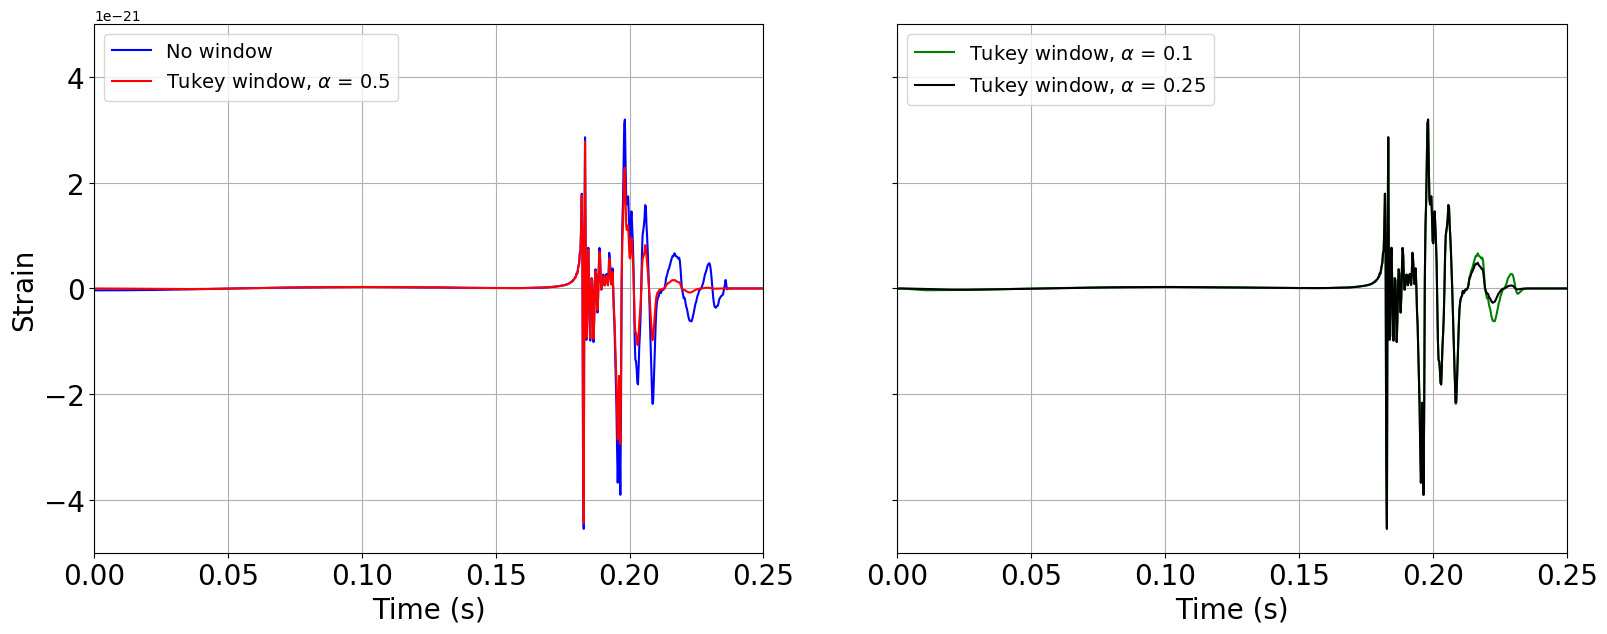

In [17]:
makeplots([0, 0.25], [-5e-21, 5e-21], random_wave_idx[0], SNewaves, SNewaves05,  SNewaves01, SNewaves025, 'upper left', 'upper left')

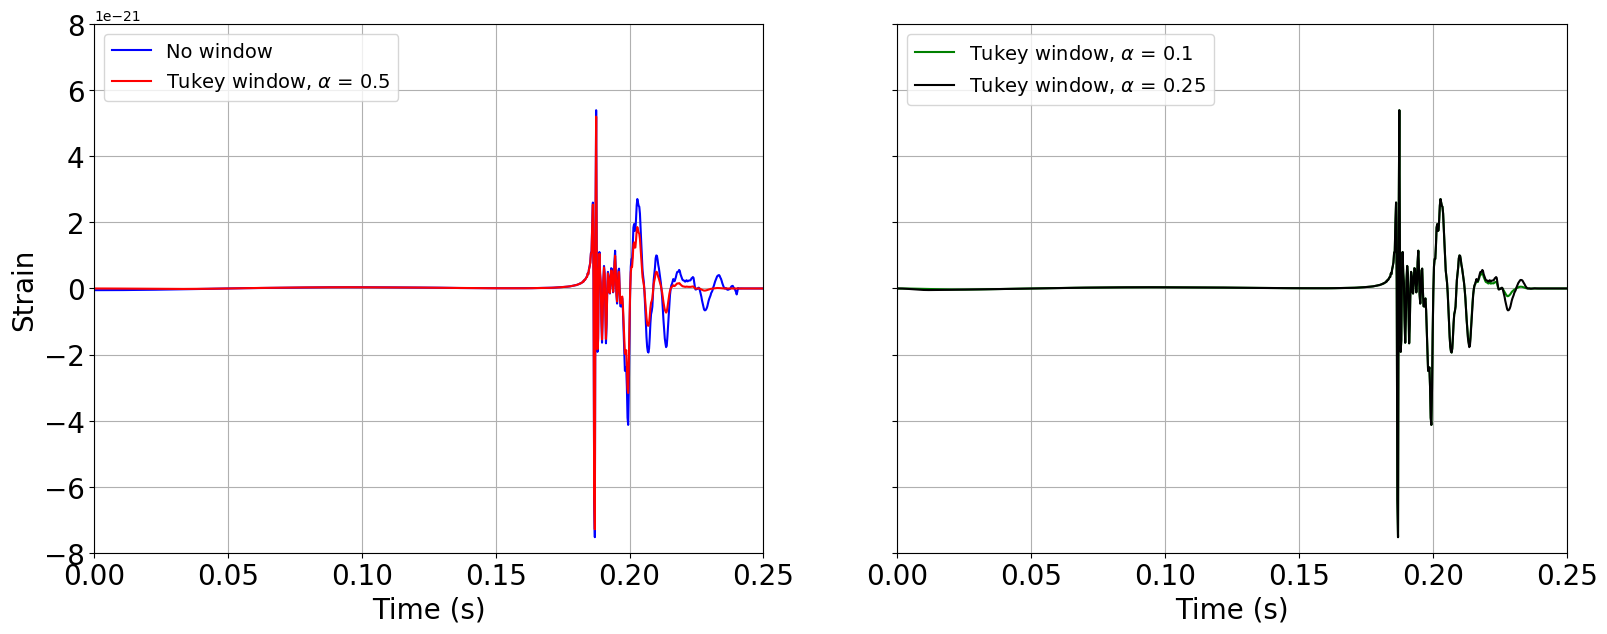

In [18]:
makeplots([0, 0.25], [-8e-21, 8e-21], random_wave_idx[1], SNewaves, SNewaves05, SNewaves025, SNewaves01, 'upper left', 'upper left')

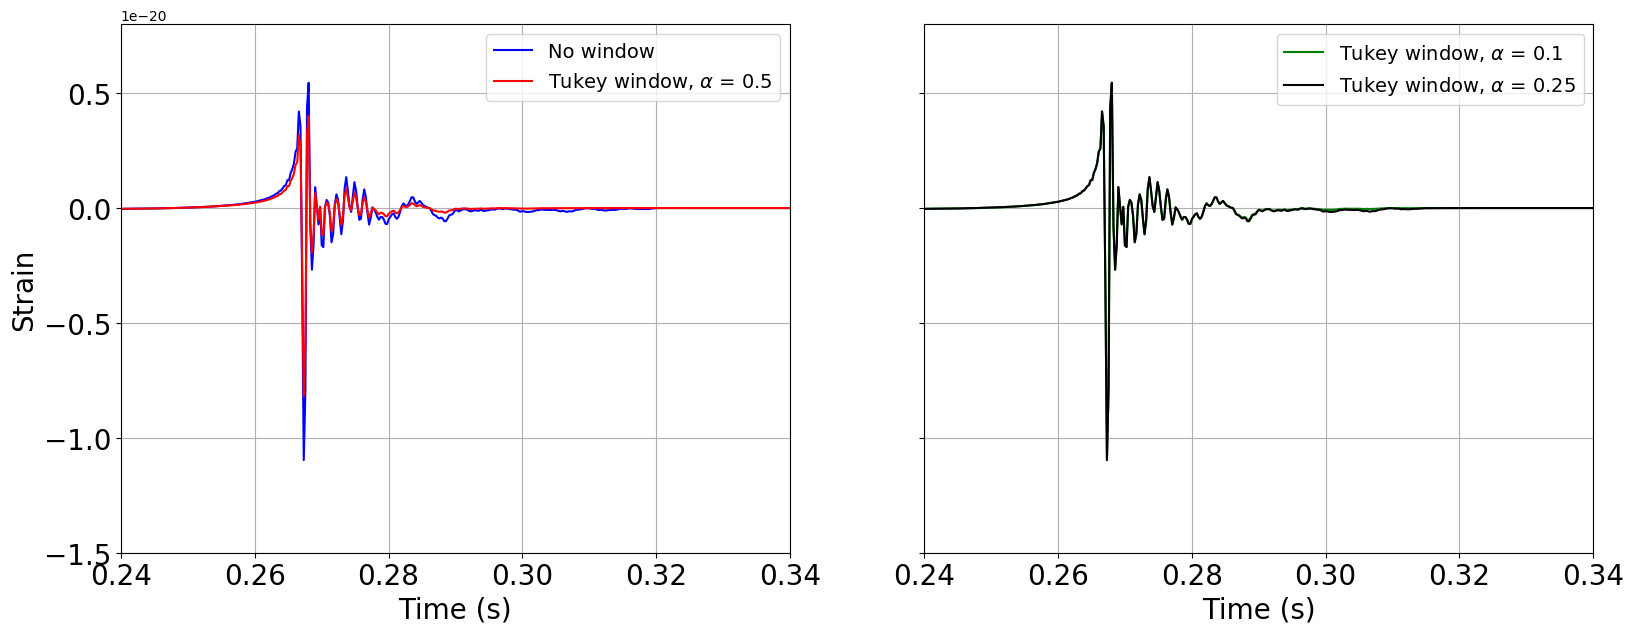

In [29]:
makeplots([0.24, 0.34], [-1.5e-20, 8e-21], random_wave_idx[2], SNewaves, SNewaves05, SNewaves025, SNewaves01, 'upper right', 'upper right')

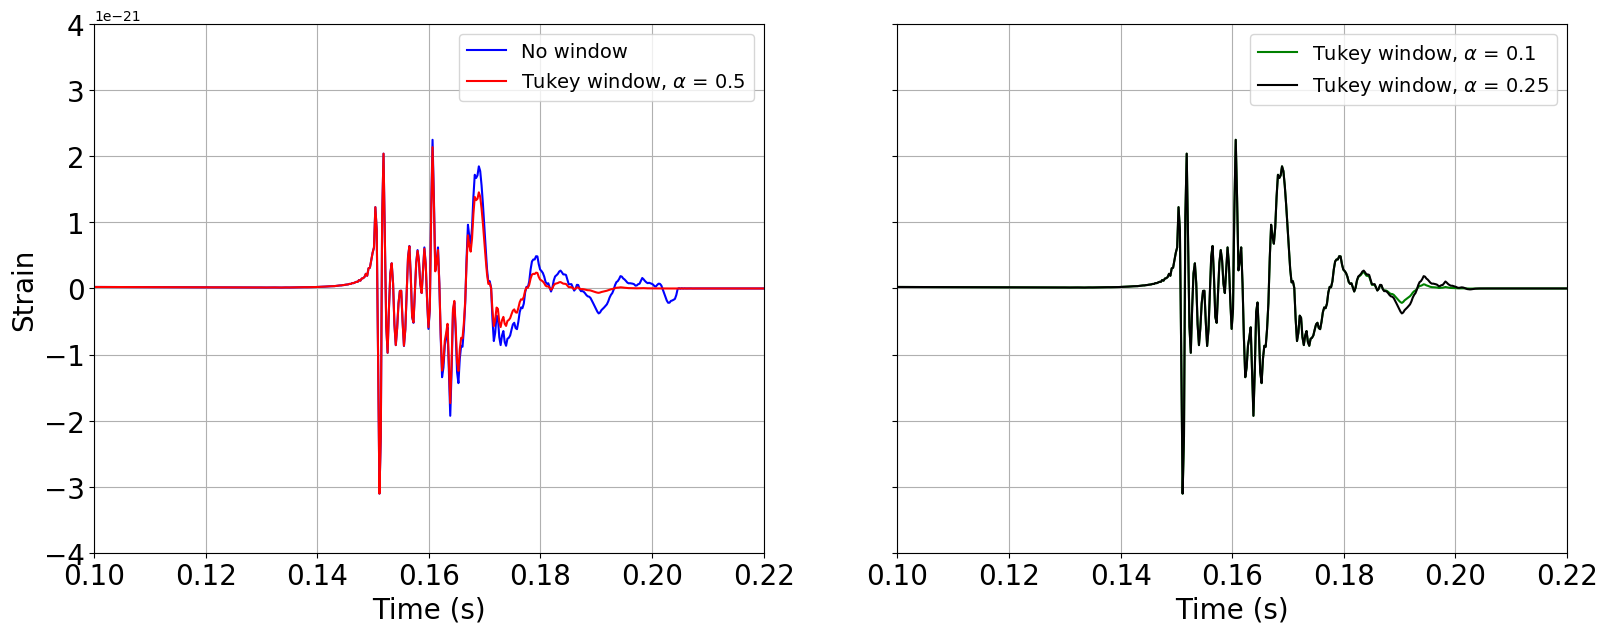

In [33]:
makeplots([0.1, 0.22], [-4e-21, 4e-21], random_wave_idx[3], SNewaves, SNewaves05, SNewaves025, SNewaves01, 'upper right', 'upper right')

## Figure 5, Tukey windows with different values of alpha 

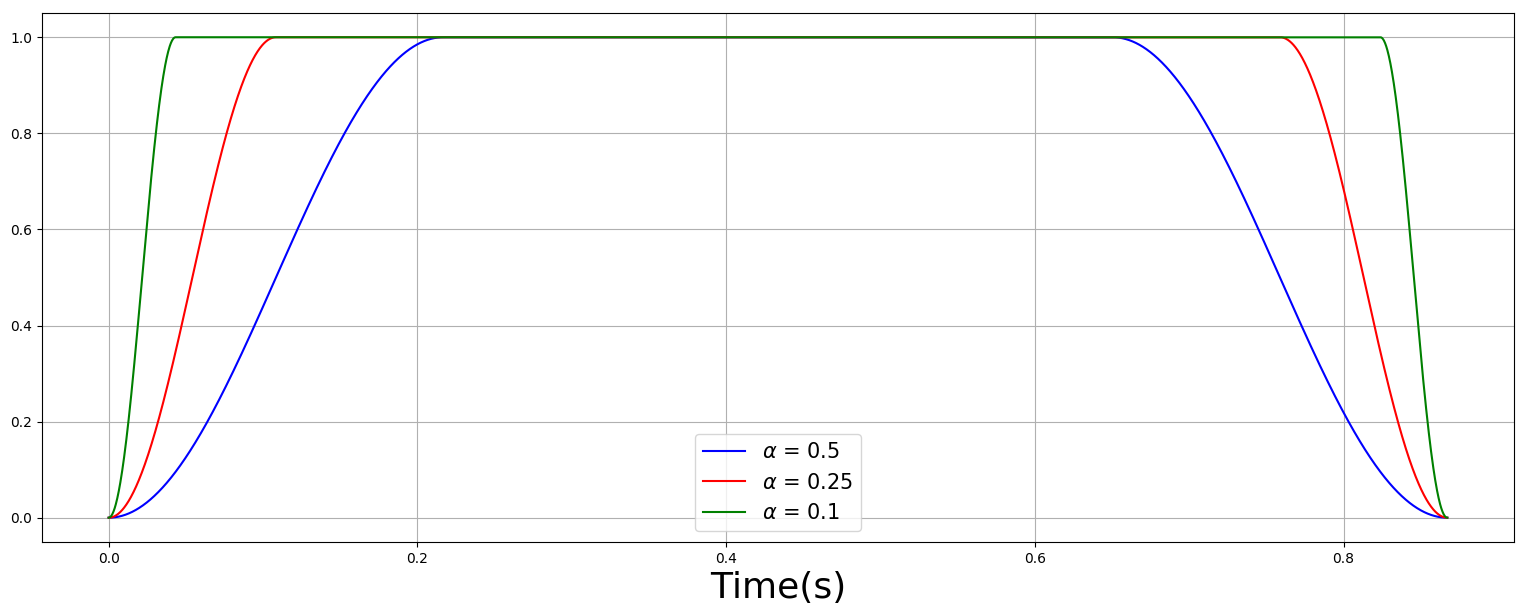

In [34]:
win1 = signal.tukey(len(SNewaves[0]), alpha = 0.5)
win2 = signal.tukey(len(SNewaves[0]), alpha = 0.25)
win3 = signal.tukey(len(SNewaves[0]), alpha = 0.1)
fig = plt.figure(figsize=(19,7), dpi= 100, facecolor='w', edgecolor='k')
tstamps = np.arange(len(SNewaves[0])) *New_dt
plt.plot(tstamps , win1, color = 'b', linewidth = 1.5, label = r'$\alpha$ = 0.5')
plt.plot(tstamps , win2, color = 'r', linewidth = 1.5, label = r'$\alpha$ = 0.25')
plt.plot(tstamps , win3, color = 'g', linewidth = 1.5, label = r'$\alpha$ = 0.1')
plt.grid()
plt.legend(fontsize = 15)
plt.xlabel('Time(s)', fontsize = 26)
plt.show()